# **Analysing a Social Network using Graph Neural Network**

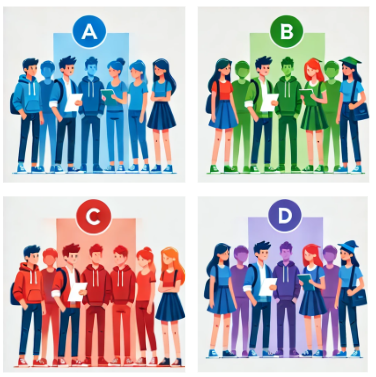

---




**Classifying the students of a university based on the countries from they come. It is observed that students coming from the same country interact more. Based on this pattern we will use a Graph Convolution Network (GCN) to classify the students.**


In [1]:
#Install the required libraries
!pip install torch_geometric                                                     # provides necessary tools and layers for implementing GNNs
!pip install optuna                                                              # hyperparameter optimization library

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.2/233.2 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 3.5 MB/s eta 0:00:00


In [2]:
import torch
from torch_geometric.datasets import KarateClub
from torch_geometric.utils import to_networkx
import networkx as nx                                                           #Library for creating, manipulating, and studying the structure, dynamics, functions of complex networks.
import matplotlib.pyplot as plt
import numpy as np
from torch.nn import Linear
from torch_geometric.nn import GCNConv

In [3]:
# Load the Karate Club dataset
dataset = KarateClub()
data = dataset[0]

In [5]:
print(data)

Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])


In [4]:
print(dataset.num_features)

34


In [6]:
import pandas as pd
# Convert node features to a pandas DataFrame
node_features_df = pd.DataFrame(data.x.numpy(), columns=[f'feature_{i}' for i in range(data.x.shape[1])])
node_features_df['node'] = node_features_df.index
node_features_df.set_index('node', inplace=True)

# Convert edge indices to a pandas DataFrame
edge_index_df = pd.DataFrame(data.edge_index.numpy().T, columns=['source', 'target'])

# Convert labels to a pandas DataFrame
labels_df = pd.DataFrame(data.y.numpy(), columns=['label'])
labels_df['node'] = labels_df.index
labels_df.set_index('node', inplace=True)

In [7]:
print(node_features_df)

      feature_0  feature_1  feature_2  feature_3  feature_4  feature_5  \
node                                                                     
0           1.0        0.0        0.0        0.0        0.0        0.0   
1           0.0        1.0        0.0        0.0        0.0        0.0   
2           0.0        0.0        1.0        0.0        0.0        0.0   
3           0.0        0.0        0.0        1.0        0.0        0.0   
4           0.0        0.0        0.0        0.0        1.0        0.0   
5           0.0        0.0        0.0        0.0        0.0        1.0   
6           0.0        0.0        0.0        0.0        0.0        0.0   
7           0.0        0.0        0.0        0.0        0.0        0.0   
8           0.0        0.0        0.0        0.0        0.0        0.0   
9           0.0        0.0        0.0        0.0        0.0        0.0   
10          0.0        0.0        0.0        0.0        0.0        0.0   
11          0.0        0.0        0.0 

In [8]:
# Print the number of nodes
num_nodes = data.num_nodes
print(f"Number of nodes: {num_nodes}")

Number of nodes: 34


In [11]:
# Print the number of edges
num_edges = data.edge_index.shape[1]
print(data.edge_index)
print(f"Number of edges: {num_edges}")

tensor([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,
          1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,
          3,  3,  3,  3,  3,  4,  4,  4,  5,  5,  5,  5,  6,  6,  6,  6,  7,  7,
          7,  7,  8,  8,  8,  8,  8,  9,  9, 10, 10, 10, 11, 12, 12, 13, 13, 13,
         13, 13, 14, 14, 15, 15, 16, 16, 17, 17, 18, 18, 19, 19, 19, 20, 20, 21,
         21, 22, 22, 23, 23, 23, 23, 23, 24, 24, 24, 25, 25, 25, 26, 26, 27, 27,
         27, 27, 28, 28, 28, 29, 29, 29, 29, 30, 30, 30, 30, 31, 31, 31, 31, 31,
         31, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 33, 33, 33, 33, 33,
         33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33],
        [ 1,  2,  3,  4,  5,  6,  7,  8, 10, 11, 12, 13, 17, 19, 21, 31,  0,  2,
          3,  7, 13, 17, 19, 21, 30,  0,  1,  3,  7,  8,  9, 13, 27, 28, 32,  0,
          1,  2,  7, 12, 13,  0,  6, 10,  0,  6, 10, 16,  0,  4,  5, 16,  0,  1,
          2,  3,  0,  2, 30, 32, 33,  2, 33,  0,  4

In [12]:
# Print node features DataFrame
print(f"\nNode features (shape: {node_features_df.shape}):")
print(node_features_df.head())  # Print only the first few rows for brevity


Node features (shape: (34, 34)):
      feature_0  feature_1  feature_2  feature_3  feature_4  feature_5  \
node                                                                     
0           1.0        0.0        0.0        0.0        0.0        0.0   
1           0.0        1.0        0.0        0.0        0.0        0.0   
2           0.0        0.0        1.0        0.0        0.0        0.0   
3           0.0        0.0        0.0        1.0        0.0        0.0   
4           0.0        0.0        0.0        0.0        1.0        0.0   

      feature_6  feature_7  feature_8  feature_9  ...  feature_24  feature_25  \
node                                              ...                           
0           0.0        0.0        0.0        0.0  ...         0.0         0.0   
1           0.0        0.0        0.0        0.0  ...         0.0         0.0   
2           0.0        0.0        0.0        0.0  ...         0.0         0.0   
3           0.0        0.0        0.0     

In [14]:
# Print edge indices DataFrame
print(f"\nEdge indices (shape: {edge_index_df.shape}):")
print(edge_index_df.head())  # Print only the first few rows for brevity


Edge indices (shape: (156, 2)):
   source  target
0       0       1
1       0       2
2       0       3
3       0       4
4       0       5


In [13]:
# Print labels DataFrame
print(f"\nLabels (shape: {labels_df.shape}):")
print(labels_df.head())  # Print only the first few rows for brevity


Labels (shape: (34, 1)):
      label
node       
0         1
1         1
2         1
3         1
4         3


In [ ]:
# Number of countries
num_countries = 4

# Assign students to countries (labels)
np.random.seed(42)  # For reproducibility
countries = torch.tensor(np.random.choice(num_countries, data.num_nodes))

# Update the labels in the data object
data.y = countries

In [15]:
# Verify the data
print(data)
print(f'x = {data.x.shape}')
print(data.x)
print(f'edge_index = {data.edge_index.shape}')
print(data.edge_index)
print(f'y = {data.y.shape}')
print(data.y)

Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])
x = torch.Size([34, 34])
tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])
edge_index = torch.Size([2, 156])
tensor([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,
          1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,
          3,  3,  3,  3,  3,  4,  4,  4,  5,  5,  5,  5,  6,  6,  6,  6,  7,  7,
          7,  7,  8,  8,  8,  8,  8,  9,  9, 10, 10, 10, 11, 12, 12, 13, 13, 13,
         13, 13, 14, 14, 15, 15, 16, 16, 17, 17, 18, 18, 19, 19, 19, 20, 20, 21,
         21, 22, 22, 23, 23, 23, 23, 23, 24, 24, 24, 25, 25, 25, 26, 26, 27, 27,
         27, 27, 28, 28, 28, 29, 29, 29, 29, 30, 30, 30, 30, 31, 31, 31, 31, 31,
         31, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 

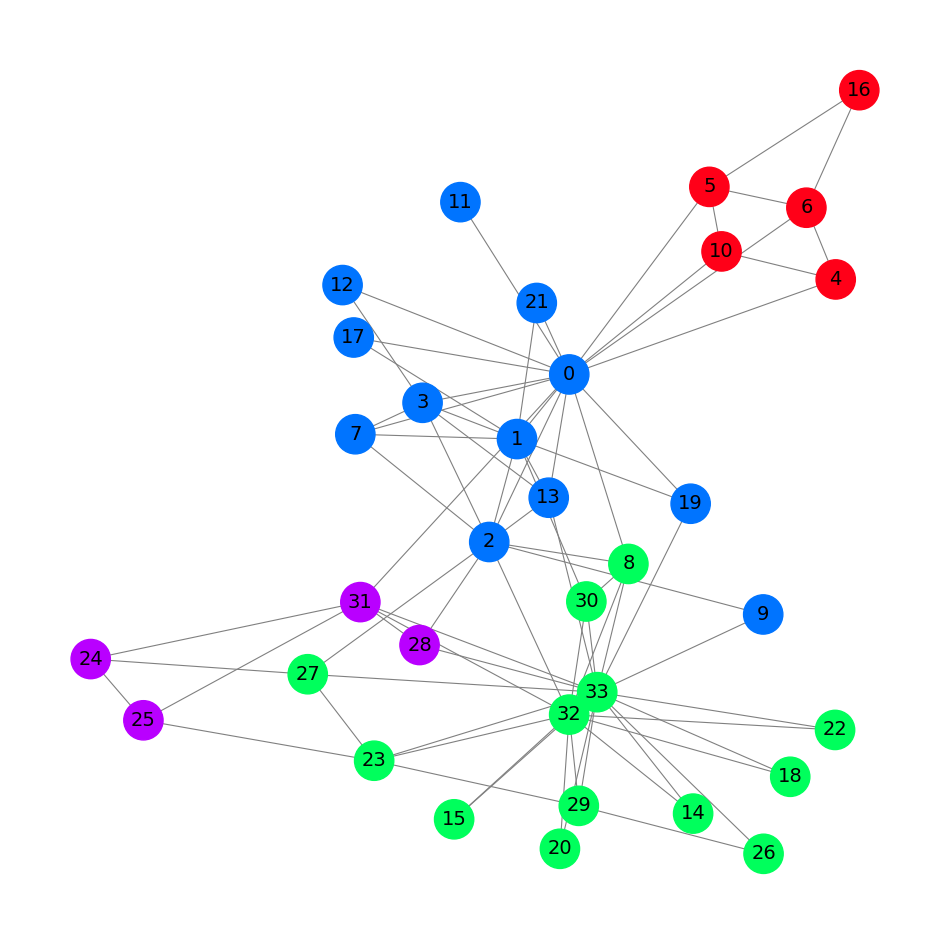

In [16]:
# Check if the graph is as expected
G = to_networkx(data, to_undirected=True)
plt.figure(figsize=(12,12))
plt.axis('off')
nx.draw_networkx(G,
                pos=nx.spring_layout(G, seed=0),
                with_labels=True,
                node_size=800,
                node_color=data.y,
                cmap="hsv",
                vmin=-2,
                vmax=3,
                width=0.8,
                edge_color="grey",
                font_size=14
                )
plt.show()

In [18]:
# Define the model
num_countries = 4
class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.gcn = GCNConv(dataset.num_features, 3)
        self.out = Linear(3, num_countries)
    def forward(self, x, edge_index):
        h = self.gcn(x, edge_index).relu()
        z = self.out(h)
        return h, z

model = GCN()
print(model)


GCN(
  (gcn): GCNConv(34, 3)
  (out): Linear(in_features=3, out_features=4, bias=True)
)


In [19]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.02)

# Calculate accuracy
def accuracy(pred_y, y):
    return (pred_y == y).sum() / len(y)


In [20]:
print(data.x)

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])


In [21]:
# Data for animations
embeddings = []
losses = []
accuracies = []
outputs = []

# Training loop
for epoch in range(200):
    optimizer.zero_grad()
    h, z = model(data.x, data.edge_index)
    loss = criterion(z, data.y)
    acc = accuracy(z.argmax(dim=1), data.y)
    loss.backward()
    optimizer.step()
    embeddings.append(h)
    losses.append(loss)
    accuracies.append(acc)
    outputs.append(z.argmax(dim=1))
    if epoch % 10 == 0:
        print(f'Epoch {epoch:>3} | Loss: {loss:.2f} | Acc: {acc*100:.2f}%')


Epoch   0 | Loss: 1.36 | Acc: 35.29%
Epoch  10 | Loss: 1.29 | Acc: 35.29%
Epoch  20 | Loss: 1.23 | Acc: 67.65%
Epoch  30 | Loss: 1.13 | Acc: 73.53%
Epoch  40 | Loss: 1.00 | Acc: 73.53%
Epoch  50 | Loss: 0.88 | Acc: 73.53%
Epoch  60 | Loss: 0.79 | Acc: 73.53%
Epoch  70 | Loss: 0.73 | Acc: 73.53%
Epoch  80 | Loss: 0.70 | Acc: 73.53%
Epoch  90 | Loss: 0.68 | Acc: 73.53%
Epoch 100 | Loss: 0.66 | Acc: 73.53%
Epoch 110 | Loss: 0.65 | Acc: 73.53%
Epoch 120 | Loss: 0.65 | Acc: 73.53%
Epoch 130 | Loss: 0.64 | Acc: 73.53%
Epoch 140 | Loss: 0.63 | Acc: 73.53%
Epoch 150 | Loss: 0.63 | Acc: 73.53%
Epoch 160 | Loss: 0.63 | Acc: 73.53%
Epoch 170 | Loss: 0.62 | Acc: 73.53%
Epoch 180 | Loss: 0.62 | Acc: 76.47%
Epoch 190 | Loss: 0.61 | Acc: 76.47%


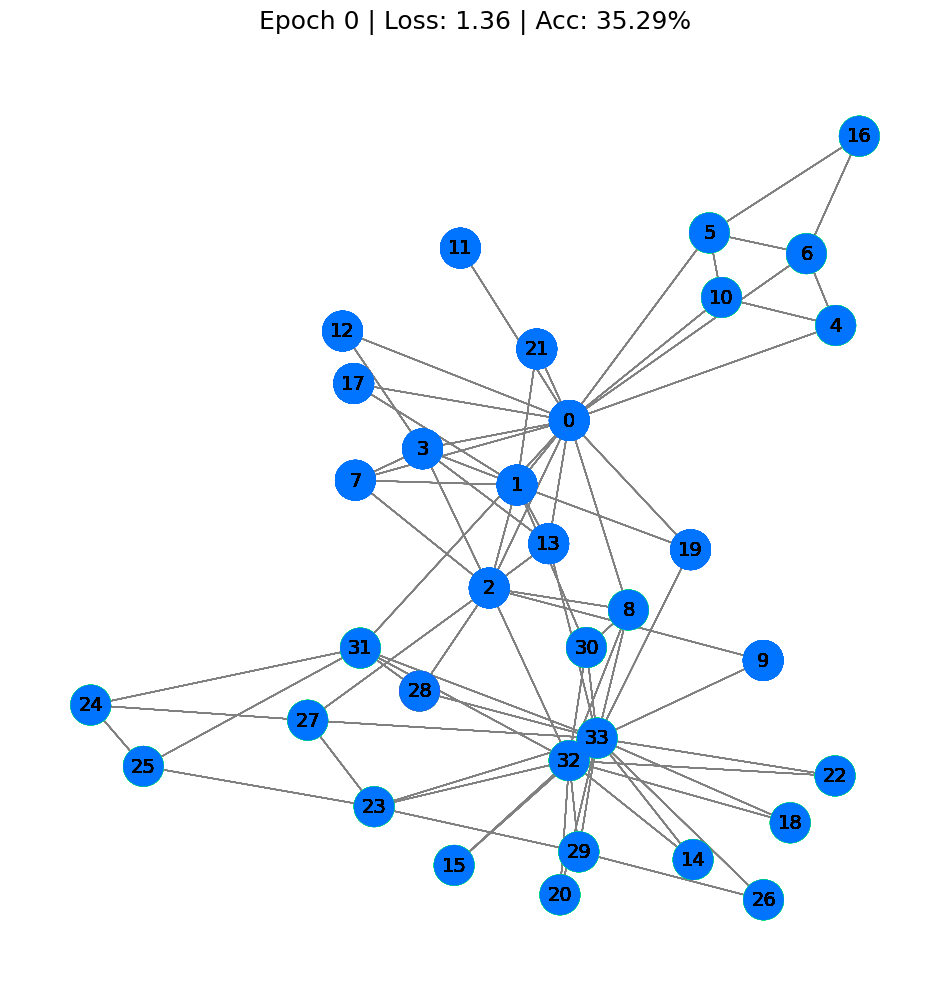

In [22]:
from IPython.display import HTML
from matplotlib import animation

plt.rcParams["animation.bitrate"] = 3000

def animate(i):
    G = to_networkx(data, to_undirected=True)
    nx.draw_networkx(G,
                    pos=nx.spring_layout(G, seed=0),
                    with_labels=True,
                    node_size=800,
                    node_color=outputs[i].numpy(),
                    cmap="hsv",
                    vmin=-2,
                    vmax=3,
                    width=0.8,
                    edge_color="grey",
                    font_size=14
                    )
    plt.title(f'Epoch {i} | Loss: {losses[i].item():.2f} | Acc: {accuracies[i].item()*100:.2f}%',
              fontsize=18, pad=20)

fig = plt.figure(figsize=(12, 12))
plt.axis('off')
anim = animation.FuncAnimation(fig, animate, np.arange(0, 200, 10), interval=500, repeat=True)
html = HTML(anim.to_html5_video())
display(html)

Final embeddings = torch.Size([34, 3])
tensor([[0.0000, 2.5441, 0.0000],
        [0.0000, 3.1481, 0.0000],
        [0.0000, 2.1361, 0.0000],
        [0.0000, 2.9528, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 2.3883, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 1.9505, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 2.3480, 0.0000],
        [0.0000, 2.4047, 0.0000],
        [0.0000, 2.1336, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 2.2947, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 2.0055, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 2.2767, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [

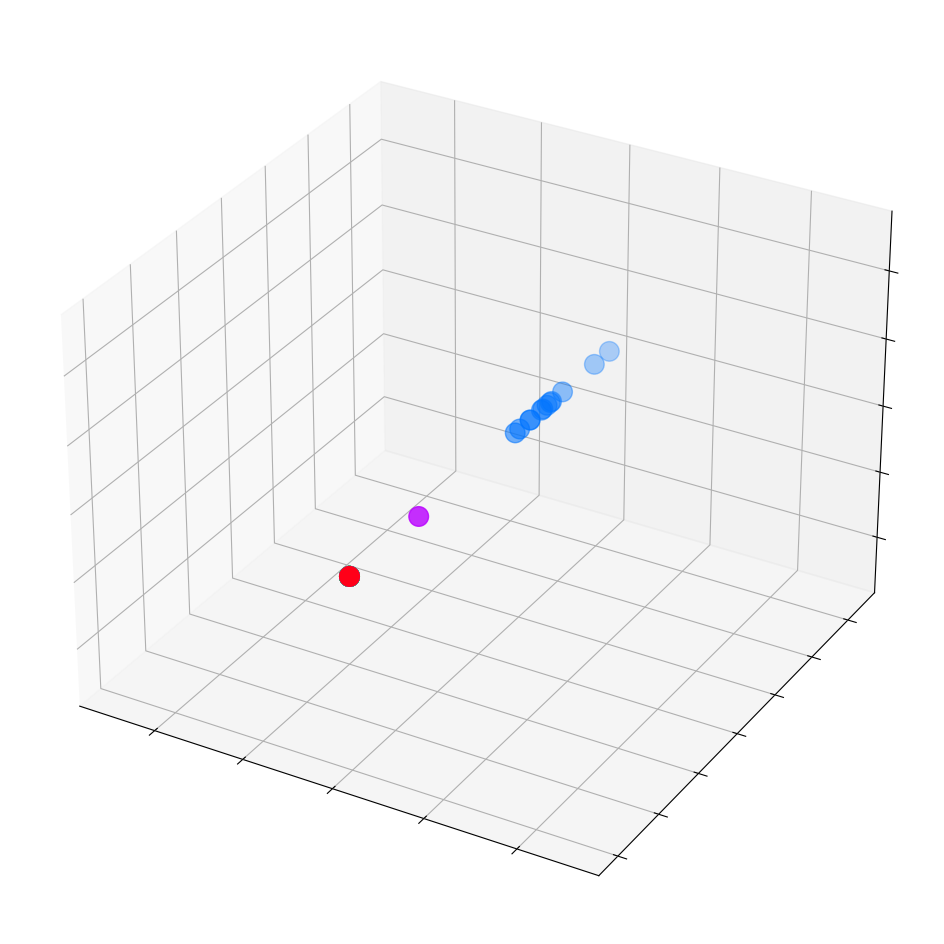

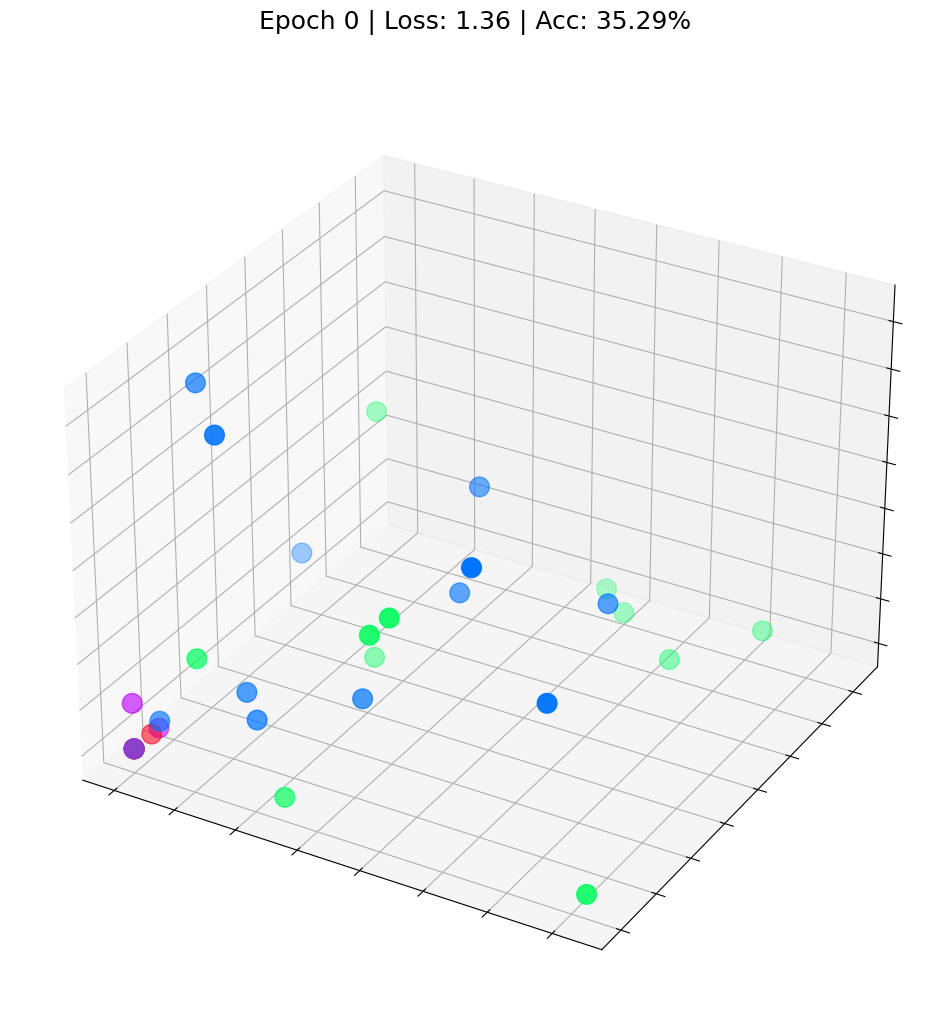

In [23]:
# 3D Embeddings Visualization
print(f'Final embeddings = {h.shape}')
print(h)

embed = h.detach().cpu().numpy()
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')
ax.patch.set_alpha(0)
plt.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
ax.scatter(embed[:, 0], embed[:, 1], embed[:, 2],
           s=200, c=data.y, cmap="hsv", vmin=-2, vmax=3)
plt.show()

def animate_3d(i):
    embed = embeddings[i].detach().cpu().numpy()
    ax.clear()
    ax.scatter(embed[:, 0], embed[:, 1], embed[:, 2],
               s=200, c=data.y, cmap="hsv", vmin=-2, vmax=3)
    plt.title(f'Epoch {i} | Loss: {losses[i].item():.2f} | Acc: {accuracies[i].item()*100:.2f}%',
              fontsize=18, pad=40)

fig = plt.figure(figsize=(12, 12))
plt.axis('off')
ax = fig.add_subplot(projection='3d')
plt.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
anim = animation.FuncAnimation(fig, animate_3d, np.arange(0, 200, 10), interval=800, repeat=True)
html = HTML(anim.to_html5_video())
display(html)